# FIT simulations

### Little bit of theory:

**Transfer entropy**: the mutual information between $Y_{pres}$ and $X_{past}$, conditioned on $Y_{past}$

$$ TE(X\rightarrow Y) = I(X_{past}; Y_{pres}|Y_{past}) $$

where

$$ I(S=s,X_i) = \sum_{x_i \in X_i} p(x_i|s)\,\log\frac{p(s|x_i)}{p(s)}$$

is the specific information that the source $X_i$ carries about a specific outcome of the target variable $s\in S$.

**FIT**:

$$ FIT = \text{min}[SUI(S: X_{past}, Y_{pres} \ Y_{past} ),\, SUI(Y_{pres}: X_{past}, S\ Y_{past})] $$

where 
- $SUI(S: X_{past}, Y_{pres} \ Y_{past} )$ is the information about $S$ that $X_{past}$ shares with $Y_{pres}$ and it's unique with respect to $Y_{past}$ and it's defined as the difference between the shared information that $X_{past}, Y_{pres}$ carry about $S$ and the shared information that $X_{past}, Y_{pres}$ and $Y_{past}$ carry about $S$
- $SUI(Y_{pres}: X_{past}, S\ Y_{past})$ is the information about $Y_{pres}$ that $X_{past}$ shares with $S$ and it's unique with respect to $Y_{past}$

Moreover

$$ SUI(S:X_1,X_2) = \sum_{s\in S} p(s) \text{min}_{X_i \in \{ X_1, X_2\} } I(S=s,X_i) $$

is the shared information that $X_1$ and $X_2$ carry about $S$.

**Sender activity**: 2D variable

$$X(t)_{stim} = S(t)(1+N(0, \sigma_{stim}))$$

where $S(t)$ is a step function equal to the value of the stimulus $s \in [1,4]$ during the time window $[200,250]\,ms$.

$$X(t)_{noise} = N(0,\sigma)$$

**Receiver activity**: 1D variable

$$Y(t) = W_{stim}X_{stim}(t-\delta) + W_{noise}X_{noise}(t-\delta) + N(0,\sigma)$$

where the **delay** $\delta$ is chosen randomly from a uniform distribution in $[40,60]\,ms$ in step of $10\,ms$, moreover $\sigma = 2$ and $\sigma_{stim} = \sigma/5 = 0.4$.

**Numerical computation of FIT**: discretization of neural activity into a number R of equipopulated bins and empirical computation of the occurence frequency of each binned response across all available trials.

FIT/TE are computed at the first time instant in which $Y$ received information from $X$.

Total of 50 simulation with 500 trials per stimulus each one.

### WHAT TO DO:

- **Fig. 2A** - evaluation of FIT and TE for each value of $W_{noise}$ and $W_{stim}$
- **Fig. 2B** - FIT and TE as a function of time with $W_{stim}=0.5$ and $W_{noise}=1$ (FIT/TE values computed at all points and averaged over delays to obtain temporal profiles of transmitted information)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sim2Aroutine import sim2Aroutine

In [2]:
# files to save the simulation results
file_2A = 'sim_file_2A.npz'
file_2B = 'sim_file_2B.npz'

# load 2A simulation file if present, otherwise perform simulations
if os.path.exists(file_2A):

    loadnpz_2A = np.load(file_2A)

    te = loadnpz_2A['te']
    dfi = loadnpz_2A['dfi']
    fit = loadnpz_2A['fit']

else:
    fit, te, dfi = sim2Aroutine()

Simulation number:  0 

Simulation number:  1 

Simulation number:  2 

Simulation number:  3 

Simulation number:  4 

Simulation number:  5 

Simulation number:  6 

Simulation number:  7 

Simulation number:  8 

Simulation number:  9 

Simulation number:  10 

Simulation number:  11 

Simulation number:  12 

Simulation number:  13 

Simulation number:  14 

Simulation number:  15 

Simulation number:  16 

Simulation number:  17 

Simulation number:  18 

Simulation number:  19 

Simulation number:  20 

Simulation number:  21 

Simulation number:  22 

Simulation number:  23 

Simulation number:  24 

Simulation number:  25 

Simulation number:  26 

Simulation number:  27 

Simulation number:  28 

Simulation number:  29 

Simulation number:  30 

Simulation number:  31 

Simulation number:  32 

Simulation number:  33 

Simulation number:  34 

Simulation number:  35 

Simulation number:  36 

Simulation number:  37 

Simulation number:  38 

Simulation number:  39 

Simulation

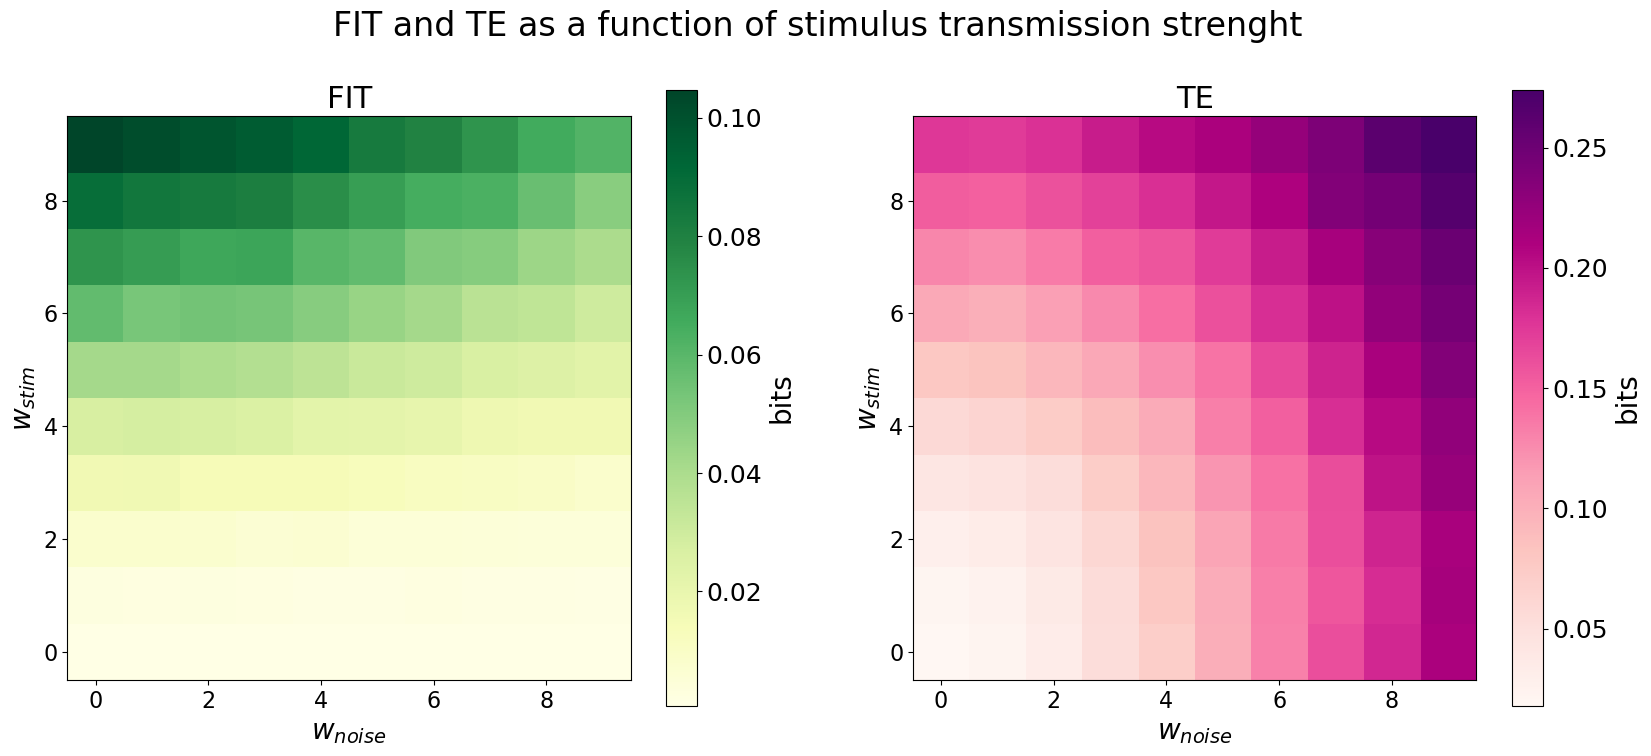

In [3]:
# heatmaps plot

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8), squeeze = False)

fitvalues = np.mean(fit, axis=0)
tevalues = np.mean(te, axis = 0)

fit_ax = ax[0][0]
te_ax = ax[0][1]

im_fit = fit_ax.imshow(fitvalues, origin='lower', cmap='YlGn')
im_te = te_ax.imshow(tevalues, origin='lower', cmap='RdPu')

fit_ax.set_title('FIT', fontsize=22)
te_ax.set_title('TE', fontsize=22)

cbar_te = te_ax.figure.colorbar(im_te, ax = te_ax)
cbar_fit = te_ax.figure.colorbar(im_fit, ax = fit_ax)

cbar_fit.set_label(label='bits', fontsize=20)
cbar_fit.ax.tick_params(labelsize = 18)

cbar_te.set_label(label='bits', fontsize=20)
cbar_te.ax.tick_params(labelsize = 18)

fit_ax.set_xlabel("$w_{noise}$", fontsize=20)
fit_ax.set_ylabel("$w_{stim}$", fontsize=20)

te_ax.set_xlabel("$w_{noise}$", fontsize=20)
te_ax.set_ylabel("$w_{stim}$", fontsize=20)

fit_ax.tick_params(axis='both', which='major', labelsize=16)
te_ax.tick_params(axis='both', which='major', labelsize=16)

te_ax.set_xlabel("$w_{noise}$")
te_ax.set_ylabel("$w_{stim}$")

plt.suptitle("FIT and TE as a function of stimulus transmission strenght", fontsize = 24)
plt.show()